# Introduction to INDRA
## Case study: modelling p53 oscillations

Here we demonstrate building a dynamical model of a molecular mechanism automatically from natural language. We look at a small system describing the oscillatory dynamics of p53 upon double-stranded DNA damage, as described in [Purvis and Lahav (2013)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3707615/), Figure 5B. Our goal will be to describe the mechanisms in this diagram in English and automatically read and assemble it into a model. The diagram in Purvis et al. simply shows activation and ihibition effects. Here we specified detailed mechanisms that are not explicitly included in the figure. Interestingly, we found that we needed to include some additional mechanisms that were not in the original diagram to reporduce the oscillatory dynamics, an example being the negative regulation of Mdm2 and Wip1 which is left out for visual clarity, but still plays a major role in dynamics. 

Below is the text describing the mechanisms we want to model.

In [1]:
model_text = \
'''
Active ATM phosphorylates ATM, and phosphorylated ATM is active.
Active ATM activates p53.
p53 is transcribed and active p53 transcribes MDM2.
MDM2 is degraded.
Active p53 activates Wip1.
Active Wip1 inactivates p53.
Active Wip1 dephosphorylates ATM.
MDM2 ubiquitinates p53 and ubiquitinated p53 is degraded.
HIPK2 inactivates Wip1.
'''

## Processing the text using TRIPS

We use INDRA's API to the TRIPS natural language processing system (http://trips.ihmc.us/parser/cgi/drum) developed by IHMC to read sentences describing molecular mechanisms and extract them as INDRA statements.

In [2]:
from indra import trips

We can pass the block of text defined above to the TRIPS processor:

In [3]:
tp = trips.process_text(model_text)

Here tp is a TripsProcessor object which contains the extacted INDRA Statements as a list. We can inspect the statements extracted by TRIPS to make sure that all of the information was extracted.

In [4]:
tp.statements

[Phosphorylation(ATM(activity: True), ATM()),
 Dephosphorylation(PPM1D(activity: True), ATM()),
 Ubiquitination(MDM2(), TP53()),
 ActiveForm(ATM(mods: (phosphorylation)), activity, True),
 Activation(ATM(activity: True), TP53()),
 Activation(TP53(activity: True), PPM1D()),
 Inhibition(PPM1D(activity: True), TP53()),
 Inhibition(HIPK2(), PPM1D()),
 DecreaseAmount(None, MDM2()),
 DecreaseAmount(None, TP53(mods: (ubiquitination))),
 IncreaseAmount(None, TP53()),
 IncreaseAmount(TP53(activity: True), MDM2())]

## Assembling a PySB model

INDRA Statements can be assembled into a number of formats and models for simulation or visualization. Next, we will assemble the statements into a PySB model which we will parametrize and run. To do this, we start by importing INDRA's PysbAssembler

In [ ]:
from indra.assemblers import PysbAssembler

Next, we instantiate a PySB assembler object.

In [6]:
pa = PysbAssembler()

The assembler takes a list of INDRA Statements as input in order to build a model.

In [7]:
pa.add_statements(tp.statements)

We finally call the assembler's `make_model` method to produce the PySB model.

In [8]:
model = pa.make_model()
model.name = 'p53_DSB_model'

## Simulating the model

We next parameterize the model for dynamical simulation and set up active p53 as an observable that we will plot. 

In [9]:
from pysb import Parameter, Observable

We add some initial active ATM to start off the reaction network.

In [10]:
model.add_component(Parameter('ATMa_0', 1))
atm_atr_m = model.monomers['ATM']
model.initial(atm_atr_m(phospho='p'),model.parameters['ATMa_0'])

Below are the parameters we define for the simulation (these override the nominal parameters automatically defined by INDRA's PySB Assembler).

In [11]:
parameters = {
    "kf_aa_phosphorylation_1": 5e-07,
    "kf_pa_dephosphorylation_1": 1e-05,
    "kf_mt_ubiquitination_1": 1e-06,
    "kf_at_act_1": 1e-07,
    "kf_tp_act_1": 1e-07,
    "kf_pt_act_1": 5e-07,
    "kf_hp_act_1": 1e-07,
    "kf_m_deg_1": 0.08,
    "kf_t_deg_1": 2e-05,
    "kf_t_synth_1": 2.0,
    "kf_tm_synth_1": 0.02,
    "HIPK2_0": 10000.0,
    "MDM2_0": 0,
    "ATM_0": 10000.0,
    "TP53_0": 10000.0,
    "PPM1D_0": 10000.0,
    "ATMa_0": 1.0,
}

for name, value in parameters.items():
    model.parameters[name].value = value

Now we set up an observable which monitors the amount of active p53 over time in order to then be able to plot this quantity. 

In [12]:
# Add active p53 observable
p53 = model.monomers['TP53']
obs = Observable('p53_active', p53(activity='active'))
model.add_component(obs)

We want to simulate the model over a relevant length of time: 24 hours, defined in seconds.

In [13]:
import numpy as np

sim_hours = 24
ts = np.linspace(0, sim_hours*3600, sim_hours*60)

We now instantiate a numerical ODE solver and run it with the model for the specified time span.

In [14]:
from pysb.integrate import Solver

solver = Solver(model, ts)
solver.run()

Finally, we plot the time course of active p53.

([], <a list of 0 Text yticklabel objects>)

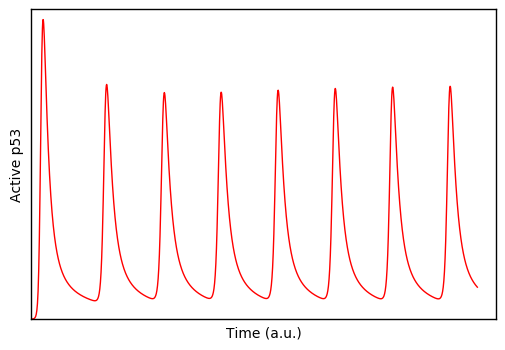

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(ts, solver.yobs['p53_active'], 'r')
plt.xticks([])
plt.xlabel('Time (a.u.)')
plt.ylabel('Active p53')
plt.yticks([])